### Load Data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

Mounted at /content/gdrive/


In [3]:
import pandas as pd
import numpy as np

In [4]:
dataPath = '/content/gdrive/My Drive/AIML/NLP/Sarcasm_Detection/Sarcasm_Detection_Data/Data/'
jsonFilePath = '/content/gdrive/My Drive/AIML/NLP/Sarcasm_Detection/Sarcasm_Detection_Data/Data/Sarcasm_Headlines_Dataset.json'
glove200_FilePath = '/content/gdrive/My Drive/AIML/NLP/Sarcasm_Detection/Sarcasm_Detection_Data/Data/glove.6B.200d.txt'
word2Vec_FilePath = '/content/gdrive/My Drive/AIML/NLP/Sarcasm_Detection/Sarcasm_Detection_Data/Data/glove.6B.200d_txt.word2vec'

In [5]:
sarcasm_df = pd.read_json(jsonFilePath,lines=True)

In [6]:
sarcasm_df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


### Drop `article_link` from dataset

In [7]:
sarcasm_df.drop(columns=['article_link'],inplace=True)

In [8]:
sarcasm_df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


### Get length of each headline and add a column for that 

In [9]:
sarcasm_df['headline_length'] = sarcasm_df.headline.str.len()

In [10]:
sarcasm_df.head()

,headline,is_sarcastic,headline_length
0,former versace store clerk sues over secret 'b...,0,78
1,the 'roseanne' revival catches up to our thorn...,0,84
2,mom starting to fear son's web series closest ...,1,79
3,"boehner just wants wife to listen, not come up...",1,84
4,j.k. rowling wishes snape happy birthday in th...,0,64


In [11]:
sarcasm_df.is_sarcastic.unique()

array([0, 1])

In [12]:
sarcasm_df.headline[0]

"former versace store clerk sues over secret 'black code' for minority shoppers"

### Initialize parameter values
- Set values for max_features, maxlen, & embedding_size
- max_features: Number of words to take from tokenizer(most frequent words)
- maxlen: Maximum length of each sentence to be limited to 25
- embedding_size: size of embedding vector

In [13]:
max_features = 10000
maxlen = 25
embedding_size = 200

### Apply `tensorflow.keras` Tokenizer and get indices for words
- Initialize Tokenizer object with number of words as 10000
- Fit the tokenizer object on headline column
- Convert the text to sequence


In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
import re

In [16]:
def preprocessing(df):
  data = df.copy(True)
  data['headline'] = data['headline'].apply(lambda x: x.lower())
  pattern = '[^a-zA-Z0-9\s]'
  data['headline'] = data['headline'].apply((lambda x: re.sub(pattern,'',x)))
  return data

data = preprocessing(sarcasm_df)
tokenizer = Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(data['headline'].values)
sequences = tokenizer.texts_to_sequences(data['headline'].values)

In [17]:
len(sarcasm_df.headline[0])

78

In [18]:
data.headline[0]

'former versace store clerk sues over secret black code for minority shoppers'

In [19]:
sequences[0]

[293, 795, 3551, 2241, 47, 359, 92, 2138, 5, 2509, 8285]

### Pad sequences
- Pad each example with a maximum length
- Convert target column into numpy array

In [20]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
after_padding_sequence = pad_sequences(sequences,maxlen=maxlen,padding='post',truncating='post')

In [21]:
after_padding_sequence[0]

array([ 293,  795, 3551, 2241,   47,  359,   92, 2138,    5, 2509, 8285,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0], dtype=int32)

### Vocab mapping
- There is no word for 0th index

In [ ]:
tokenizer.word_index

### Set number of words
- Since the above 0th index doesn't have a word, add 1 to the length of the vocabulary

In [22]:
num_words = len(tokenizer.word_index) + 1
print(num_words)

28400


### Load Glove Word Embeddings

In [23]:
from gensim.models import  KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove2word2vec(glove200_FilePath,'glove.6B.200d_txt.word2vec')
model = KeyedVectors.load_word2vec_format('glove.6B.200d_txt.word2vec')


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### Create embedding matrix

In [24]:
EMBEDDING_FILE =  glove200_FilePath
# ./glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, 200))

for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

### Define model
- Hint: Use Sequential model instance and then add Embedding layer, Bidirectional(LSTM) layer, then dense and dropout layers as required. 
In the end add a final dense layer with sigmoid activation for binary classification.

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Dense,Bidirectional,LSTM, Dropout,SeparableConv1D
from tensorflow.keras.utils import  plot_model

In [56]:
model = Sequential()
model.add(Embedding(max_features,embedding_size,input_length=maxlen))
model.add(Bidirectional(LSTM(196,dropout=0.2,return_sequences=True)))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [57]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 25, 200)           2000000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 25, 392)           622496    
_________________________________________________________________
dense_6 (Dense)              (None, 25, 100)           39300     
_________________________________________________________________
dropout_3 (Dropout)          (None, 25, 100)           0         
_________________________________________________________________
dense_7 (Dense)              (None, 25, 1)             101       
Total params: 2,661,897
Trainable params: 2,661,897
Non-trainable params: 0
_________________________________________________________________


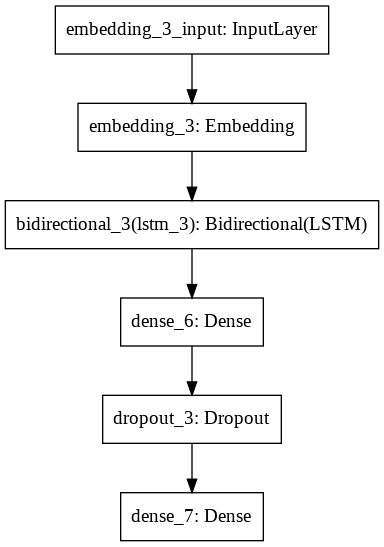

In [58]:
plot_model(model,'Sarcasm_detection_model.png')

### Compile the model

In [59]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

### Fit the model

In [48]:
from sklearn.model_selection import train_test_split

In [60]:
y =  data.is_sarcastic.values
type(y)

numpy.ndarray

In [61]:
X_train,X_test,y_train,y_test = train_test_split(after_padding_sequence,y,test_size=0.2,random_state=42)

In [62]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(21367, 25) (21367,)
(5342, 25) (5342,)


In [65]:
batch_size = 42
model.fit(X_train,y_train,epochs=10,batch_size=batch_size,verbose=1,validation_split=0.2)

Epoch 1/10
407/407 [==============================] - 12s 29ms/step - loss: 0.0154 - accuracy: 0.9949 - val_loss: 0.6052 - val_accuracy: 0.9117
Epoch 2/10
407/407 [==============================] - 11s 28ms/step - loss: 0.0104 - accuracy: 0.9969 - val_loss: 0.7180 - val_accuracy: 0.9089
Epoch 3/10
407/407 [==============================] - 12s 29ms/step - loss: 0.0072 - accuracy: 0.9976 - val_loss: 0.7245 - val_accuracy: 0.9067
Epoch 4/10
407/407 [==============================] - 11s 28ms/step - loss: 0.0069 - accuracy: 0.9977 - val_loss: 0.6994 - val_accuracy: 0.9035
Epoch 5/10
407/407 [==============================] - 12s 28ms/step - loss: 0.0041 - accuracy: 0.9986 - val_loss: 0.7930 - val_accuracy: 0.9038
Epoch 6/10
407/407 [==============================] - 12s 28ms/step - loss: 0.0066 - accuracy: 0.9981 - val_loss: 0.7521 - val_accuracy: 0.9068
Epoch 7/10
407/407 [==============================] - 12s 29ms/step - loss: 0.0054 - accuracy: 0.9983 - val_loss: 0.8074 - val_accuracy:

In [66]:
model.evaluate(X_test,y_test)

167/167 [==============================] - 1s 5ms/step - loss: 1.7000 - accuracy: 0.8362


[1.6999695301055908, 0.8362414240837097]